In [7]:
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import umap, numpy as np, pandas as pd

from nltk import FreqDist

import pandas as pd

from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm


from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import umap

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Or for specific warning types:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
labyrinthus_df = pd.read_parquet("../data/large_files/labyrinthus_embeddings.parquet")

In [25]:
REDUCTIONS = {
    # --- UMAP variants ---
    "umap_10_0.05": lambda: umap.UMAP(n_neighbors=10,  min_dist=0.05,
                                      metric="cosine", random_state=42),
    "umap_50_0.5" : lambda: umap.UMAP(n_neighbors=50,  min_dist=0.5 ,
                                      metric="cosine", random_state=42),
    "umap_100_0.8": lambda: umap.UMAP(n_neighbors=100, min_dist=0.8,
                                      metric="cosine", random_state=42),
    # --- t-SNE variants ---
    "tsne_10": lambda: TSNE(n_components=2, perplexity=10,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_30": lambda: TSNE(n_components=2, perplexity=30,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_50": lambda: TSNE(n_components=2, perplexity=50,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    # --- PCA variants ---
    "pca_std"   : lambda: PCA(n_components=2, whiten=False , random_state=42),
    "pca_whiten": lambda: PCA(n_components=2, whiten=True  , random_state=42),
    # --- PCA→t-SNE speed trick ---
    "pca10_tsne": lambda: (
        lambda X: TSNE(n_components=2, perplexity=30,
                       init="pca", random_state=42)
                  .fit_transform(PCA(n_components=10, random_state=42)
                                 .fit_transform(X))
    )
}

def get_2d(df, columns, projection):
    concat_rows = [
        np.concatenate([df[col].iloc[i] for col in columns])
        for i in range(len(df))]
    emb = np.stack(concat_rows)
    reducer = projection()
    if hasattr(reducer, "fit_transform"):
            embedding_2d = reducer.fit_transform(emb)
    else:                      # callable expecting X directly (pca10_tsne)
            embedding_2d = reducer(emb)
    return embedding_2d[:, 0], embedding_2d[:, 1]

# ------------------------------------------------------------------
# 1)  Obtain pallette
unique_lbls = sorted(labyrinthus_df["classification_single_label"].unique())
N = len(unique_lbls)
# Pick a discrete palette, extend if labels > 20
cmap_name = "tab20" if N > 10 else "tab10"
cmap = cm.get_cmap(cmap_name, N)

palette = {
    lbl: cmap(i)
    for i, lbl in enumerate(unique_lbls)
}

In [34]:
labyrinthus_df.columns[:30]

Index(['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end', 'classification_single',
       'classification_single_label', 'xlmr_sentence', 'xlmr_sp_tokens',
       'xlmr_aug_tokens', 'xlmr_conc_text', 'xlmr_conc_sp_tokens',
       'xlmr_conc_aug_tokens', 'labert_sentence', 'labert_sp_tokens',
       'labert_aug_tokens', 'labert_conc_text'],
      dtype='object')

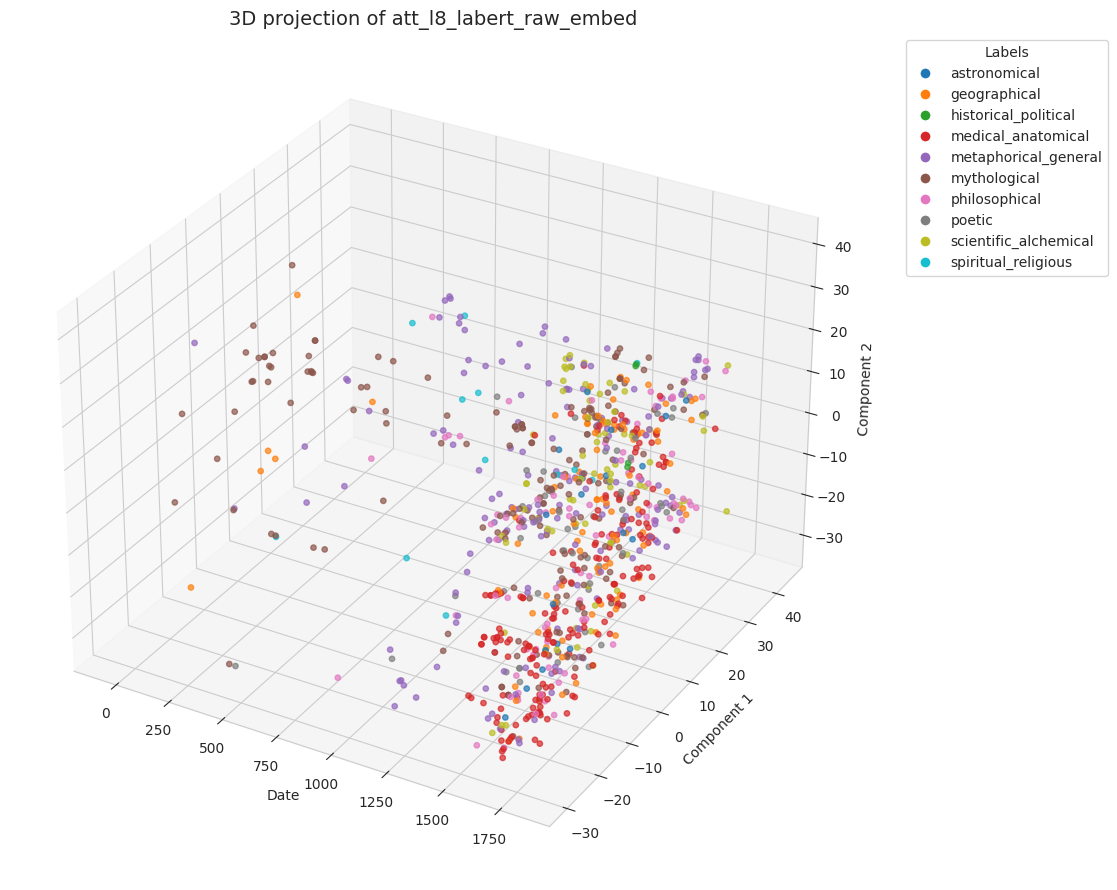

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from matplotlib.lines import Line2D

# Embeddings and labels
emb_cols_list = ["att_l8_labert_raw_embed"]
label = "&".join(emb_cols_list)
xs = labyrinthus_df["date_random"].values
ys, zs = get_2d(labyrinthus_df, emb_cols_list, REDUCTIONS["pca10_tsne"])
colors = labyrinthus_df["classification_single_label"].map(palette)

# 3D scatter plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs, ys, zs, c=colors, s=15, alpha=0.7)

ax.set_title(f"3D projection of {label}", fontsize=14)
ax.set_ylabel("Component 1")
ax.set_zlabel("Component 2")
ax.set_xlabel("Date")

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=str(lbl),
           markerfacecolor=palette[lbl], markersize=8)
    for lbl in unique_lbls
]
ax.legend(handles=legend_elements, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()